# ステップ25　計算グラフの可視化 (1)

https://qiita.com/msuz/items/bd41a8fe67fd56707116

In [1]:
import graphviz
display(graphviz.__version__)

'0.20.1'

### DOT言語でグラフを書く

In [86]:
from graphviz import Digraph
dot = Digraph()

# ノードの属性を設定
dot.attr('node', shape='circle')

# ノードを登録
dot.node('P', 'P')
dot.node('D', 'D')
dot.node('C', 'C')
dot.node('A', 'A')


# エッジの属性を登録
dot.attr('edge', arrowsize='2')

# エッジを登録
dot.edge('P', 'D')
dot.edge('D', 'C')
dot.edge('C', 'A')
dot.edge('A', 'P')

# 生成されたソースコードを確認
print(dot)

# 出力フォーマットを指定
dot.engine = 'circo'
dot.filename = 'PDCA'
dot.format = 'png'
dot.render(view = True)

digraph {
	node [shape=circle]
	P [label=P]
	D [label=D]
	C [label=C]
	A [label=A]
	edge [arrowsize=2]
	P -> D
	D -> C
	C -> A
	A -> P
}



'PDCA.png'

### ノードの属性を指定する・ノードを結ぶ

In [87]:
from graphviz import Digraph
dot = Digraph()

# ノードの属性を設定
dot.attr('node', shape='circle', color='orange',style='filled')
# ノードを登録
dot.node('P', 'P')
dot.node('D', 'D')
dot.node('C', 'C')


# ノードの属性を設定
dot.attr('node', shape='box', color='lightblue',style='filled')
# ノードを登録
dot.node('A', 'A')


# エッジの属性を登録
dot.attr('edge', arrowsize='2')

# エッジを登録
dot.edge('P', 'D')
dot.edge('D', 'C')
dot.edge('C', 'A')
dot.edge('A', 'P')

# 生成されたソースコードを確認
print(dot)

# 出力フォーマットを指定
dot.engine = 'circo'
dot.filename = 'PDCA'
dot.format = 'png'
dot.render(view = True)

digraph {
	node [color=orange shape=circle style=filled]
	P [label=P]
	D [label=D]
	C [label=C]
	node [color=lightblue shape=box style=filled]
	A [label=A]
	edge [arrowsize=2]
	P -> D
	D -> C
	C -> A
	A -> P
}



'PDCA.png'

In [4]:
from graphviz import Digraph
dot = Digraph()

# ノードの属性を設定
dot.attr('node', shape='circle', color='orange',style='filled')
# ノードを登録
dot.node('x', 'x')
dot.node('y', 'y')

# ノードの属性を設定
dot.attr('node', shape='box', color='lightblue',style='filled')
# ノードを登録
dot.node('Exp', 'Exp')


# エッジの属性を登録
dot.attr('edge', arrowsize='2')

# エッジを登録
dot.edge('x', 'Exp')
dot.edge('Exp', 'y')


# 生成されたソースコードを確認
print(dot)

# 出力フォーマットを指定
dot.engine = 'circo'
dot.filename = 'PDCA'
dot.format = 'png'
dot.render(view = True)

digraph {
	node [color=orange shape=circle style=filled]
	x [label=x]
	y [label=y]
	node [color=lightblue shape=box style=filled]
	Exp [label=Exp]
	edge [arrowsize=2]
	x -> Exp
	Exp -> y
}



'PDCA.png'

# ステップ26 計算グラフの可視化 (2)

*モジュール等のインポート

core_simple.py

In [5]:
import weakref
import numpy as np
import contextlib


# =============================================================================
# Config
# =============================================================================
class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


# =============================================================================
# Variable / Function
# =============================================================================
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 四則演算 / 演算子のオーバーロード
# =============================================================================
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow

 __init__.pyの抜粋

In [6]:
# 演算子のオーバーロード
setup_variable()
__version__ = '0.0.13'

## 26.2 計算グラフからDOT言語への変換

### ●VariableインスタンスをDOT言語に変換する関数

In [7]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)

    return dot_var.format(id(v), name) 
        # id関数：変数ノードのIDを一意にする為に、id関数でオブジェクトのIDを取得しそれを利用
        # formatメソッド：文字列中に含まれる{}という文字をformatの引数に与えたオブジェクトに置き換え

In [8]:
x = Variable(np.random.randn(2, 3))
x.name = 'x'
print('◆verbose=False')
print(_dot_var(x))
print('◆verbose=True　　の時、ndarrayインスタンスの「形状」と「型」も合わせてラベルとして出力')
print(_dot_var(x, verbose=True))

◆verbose=False
140494001805728 [label="x", color=orange, style=filled]

◆verbose=True　　の時、ndarrayインスタンスの「形状」と「型」も合わせてラベルとして出力
140494001805728 [label="x: (2, 3) float64", color=orange, style=filled]



In [99]:
# 平均0標準偏差1の正規分布の乱数配列を生成
print('引数無し')
print(np.random.randn())
print('引数あり')
print(np.random.randn(2))
print('引数あり')
print(np.random.randn(2, 3))

引数無し
0.9035766808362491
引数あり
[ 1.13952147 -0.07527643]
引数あり
[[-2.18203157 -0.28303955 -0.70459332]
 [-1.37159995 -0.02155408  0.21679606]]


https://www.headboost.jp/numpy-random-randn/

### ●DeZeroの関数をDOT言語に変換する関数

In [10]:
def _dot_func(f):
    # for function
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    ret = dot_func.format(id(f), f.__class__.__name__)

    # for edge
    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        ret += dot_edge.format(id(x), id(f))
    for y in f.outputs:  # y is weakref
        ret += dot_edge.format(id(f), id(y()))
    return ret

In [11]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

140494001807264 [label="Add", color=lightblue, style=filled, shape=box]
140494001807120 -> 140494001807264
140494001806304 -> 140494001807264
140494001807264 -> 140494001806160



![計算グラフ](計算グラフ.png)

### ●計算グラフの可視化関数

In [50]:
def get_dot_graph(output, verbose=True):
    """Generates a graphviz DOT text of a computational graph.

    Build a graph of functions and variables backward-reachable from the
    output. To visualize a graphviz DOT text, you need the dot binary from the
    graphviz package (www.graphviz.org).

    Args:
        output (dezero.Variable): Output variable from which the graph is
            constructed.
        verbose (bool): If True the dot graph contains additional information
            such as shapes and dtypes.

    Returns:
        str: A graphviz DOT text consisting of nodes and edges that are
            backward-reachable from the output
    """
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)
            seen_set.add(f)

    add_func(output.creator)
    txt += _dot_var(output, verbose)
    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)

            if x.creator is not None:
                add_func(x.creator)
    print('digraph g {\n' + txt + '}') #追加
    return 'digraph g {\n' + txt + '}'

### 26.3 画像化まで含めた変換

In [51]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)

    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    extension = os.path.splitext(to_file)[1][1:]  # Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

    # Return the image as a Jupyter Image object, to be displayed in-line.
    try:
        from IPython import display
        return display.Image(filename=to_file)
    except:
        pass

digraph g {
140494005598000 [label="z", color=orange, style=filled]
140494005598096 [label="Add", color=lightblue, style=filled, shape=box]
140494005598288 -> 140494005598096
140494005599776 -> 140494005598096
140494005598096 -> 140494005598000
140494005598288 [label="x", color=orange, style=filled]
140494005599776 [label="y", color=orange, style=filled]
}


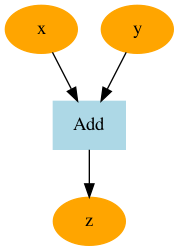

In [65]:
# addの可視化
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = x + y
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='add.png')

digraph g {
140494050841456 [label="z", color=orange, style=filled]
140494005597712 [label="Pow", color=lightblue, style=filled, shape=box]
140494005597568 -> 140494005597712
140494005597712 -> 140494050841456
140494005597568 [label="", color=orange, style=filled]
140494005598288 [label="Add", color=lightblue, style=filled, shape=box]
140494005597616 -> 140494005598288
140494053719536 -> 140494005598288
140494005598288 -> 140494005597568
140494005597616 [label="x", color=orange, style=filled]
140494053719536 [label="y", color=orange, style=filled]
}


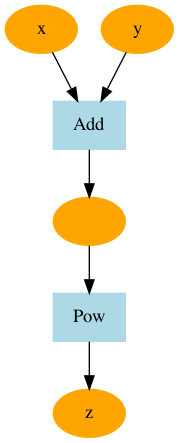

In [102]:
# 例2
x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = (x + y)**2
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='example2.png')

digraph g {
140494050161472 [label="z", color=orange, style=filled]
140494050163104 [label="Mul", color=lightblue, style=filled, shape=box]
140494050526592 -> 140494050163104
140494050163680 -> 140494050163104
140494050163104 -> 140494050161472
140494050526592 [label="", color=orange, style=filled]
140494050163680 [label="", color=orange, style=filled]
140494050163536 [label="Add", color=lightblue, style=filled, shape=box]
140494050163152 -> 140494050163536
140494050163776 -> 140494050163536
140494050163536 -> 140494050163680
140494050163152 [label="", color=orange, style=filled]
140494050163776 [label="", color=orange, style=filled]
140494050164112 [label="Mul", color=lightblue, style=filled, shape=box]
140494050161904 -> 140494050164112
140494050164640 -> 140494050164112
140494050164112 -> 140494050163152
140494050161904 [label="", color=orange, style=filled]
140494050164640 [label="", color=orange, style=filled]
140494050162144 [label="Add", color=lightblue, style=filled, shape=box]

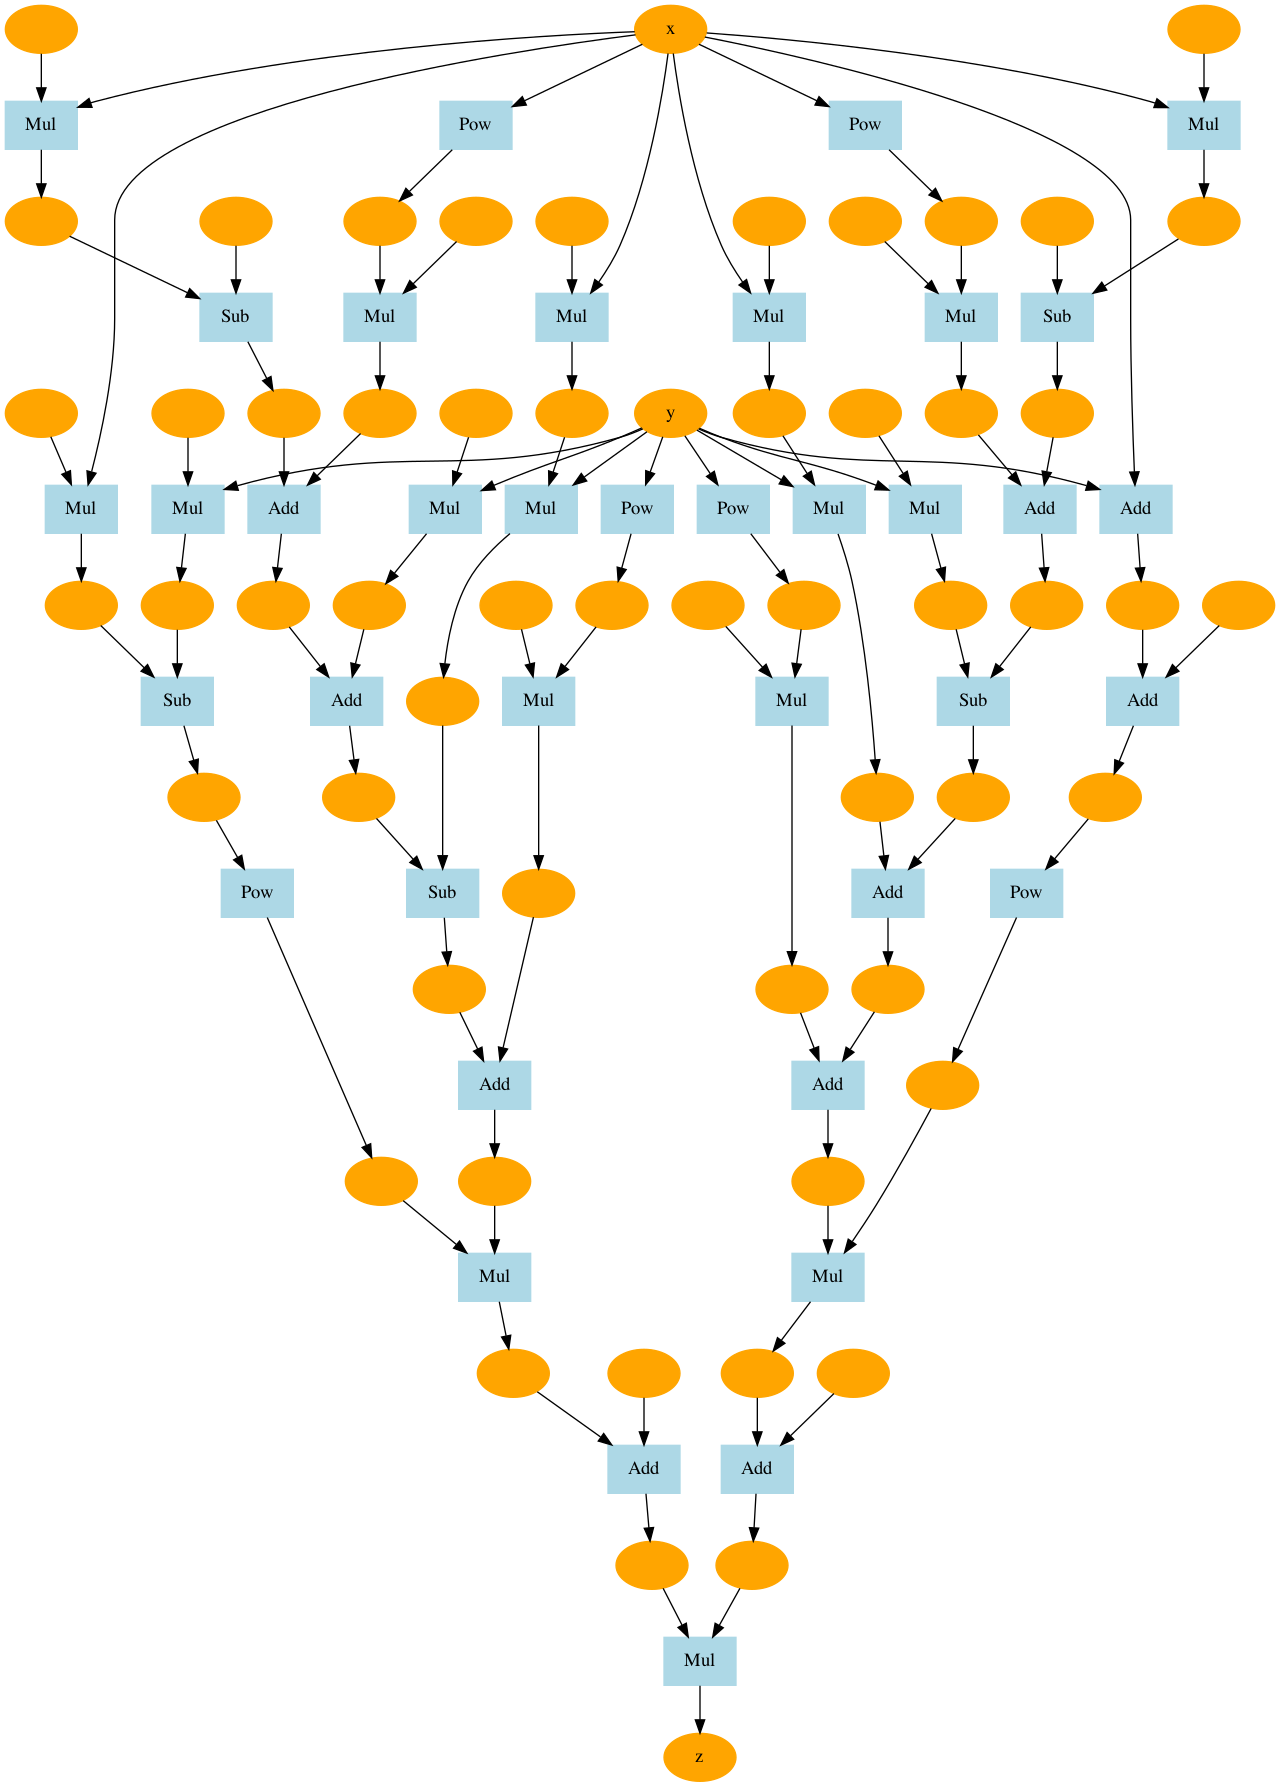

In [49]:
'''
Need the dot binary from the graphviz package (www.graphviz.org).
'''
# if '__file__' in globals():
#     import os, sys
#     sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
# import numpy as np
# from dezero import Variable
# from dezero.utils import plot_dot_graph


def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

# ステップ27 テイラー展開の微分

### 27.1 sin関数の実装

In [67]:
import math
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x):
    return Sin()(x)


x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
print(y.data)
print(x.grad)

--- original sin ---
0.7071067811865475
0.7071067811865476


digraph g {
140494050164448 [label="y", color=orange, style=filled]
140494050164640 [label="Sin", color=lightblue, style=filled, shape=box]
140494050164208 -> 140494050164640
140494050164640 -> 140494050164448
140494050164208 [label="x", color=orange, style=filled]
}


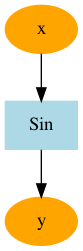

In [68]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin1.png')

### 27.2 テイラー展開の理論

In [69]:
def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y


x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

--- approximate sin ---
0.7071064695751781
0.7071032148228457


digraph g {
140494050527552 [label="y", color=orange, style=filled]
140494050525248 [label="Add", color=lightblue, style=filled, shape=box]
140494050130384 -> 140494050525248
140494050525488 -> 140494050525248
140494050525248 -> 140494050527552
140494050130384 [label="", color=orange, style=filled]
140494050525488 [label="", color=orange, style=filled]
140494050130672 [label="Mul", color=lightblue, style=filled, shape=box]
140494050129376 -> 140494050130672
140494050526880 -> 140494050130672
140494050130672 -> 140494050525488
140494050129376 [label="", color=orange, style=filled]
140494050526880 [label="", color=orange, style=filled]
140494050131056 [label="Pow", color=lightblue, style=filled, shape=box]
140494050129040 -> 140494050131056
140494050131056 -> 140494050129376
140494050129040 [label="x", color=orange, style=filled]
140494050129424 [label="Add", color=lightblue, style=filled, shape=box]
140494050131008 -> 140494050129424
140494050130288 -> 140494050129424
140494050129424 ->

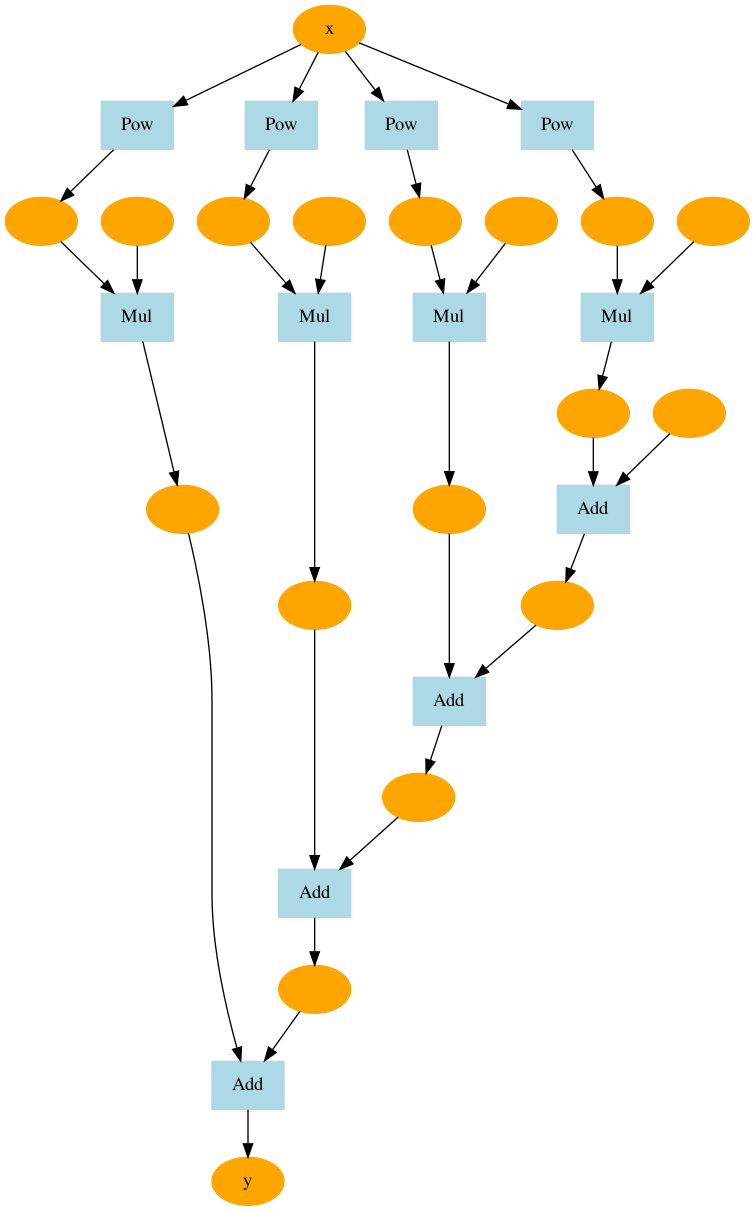

In [70]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

In [56]:
def my_sin(x, threshold=0.00000001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y


x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

--- approximate sin ---
0.7071067811796194
0.7071067810719247


digraph g {
140494050128848 [label="y", color=orange, style=filled]
140494050130144 [label="Add", color=lightblue, style=filled, shape=box]
140494050129472 -> 140494050130144
140494050130288 -> 140494050130144
140494050130144 -> 140494050128848
140494050129472 [label="", color=orange, style=filled]
140494050130288 [label="", color=orange, style=filled]
140494050131584 [label="Mul", color=lightblue, style=filled, shape=box]
140494050128800 -> 140494050131584
140494050131680 -> 140494050131584
140494050131584 -> 140494050130288
140494050128800 [label="", color=orange, style=filled]
140494050131680 [label="", color=orange, style=filled]
140494050130864 [label="Pow", color=lightblue, style=filled, shape=box]
140494005599776 -> 140494050130864
140494050130864 -> 140494050128800
140494005599776 [label="x", color=orange, style=filled]
140494050129808 [label="Add", color=lightblue, style=filled, shape=box]
140494050128944 -> 140494050129808
140494050130768 -> 140494050129808
140494050129808 ->

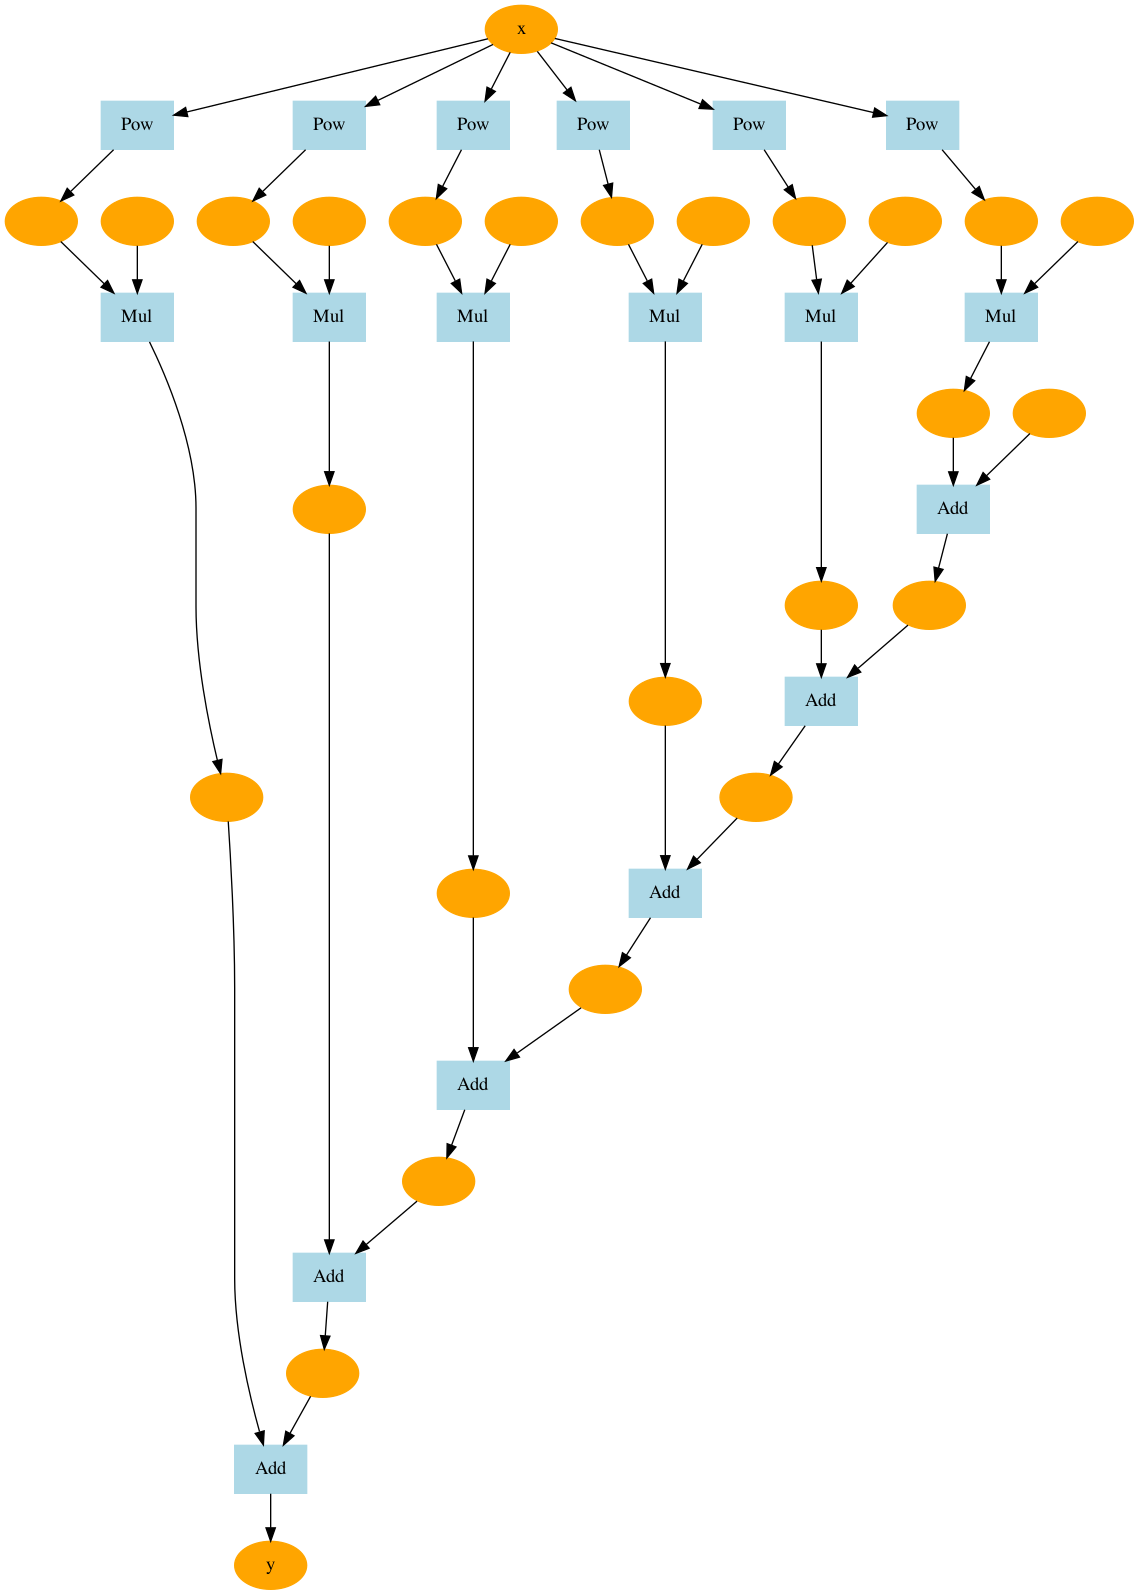

In [57]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

# ステップ28 関数の最適化

### 28.1 ローゼンブロック関数

$$
y=100(x_1-x_0^2)^2+(x_0-1)^2
$$

![rosenbrock](rosenbrock.png)

ローゼンブロック関数の最小値：
$$
(x_0, x_1)=(1, 1)
$$

### 28.2　微分を求める

In [20]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

In [21]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


上のコードを実行すると、x0、x1 の微分はそれぞれ-2.0、400.0 になります。この
とき、この2 つの微分をまとめたもの― (-2.0, 400.0) とベクトルの形にしたも
の―は、勾配（gradient）や勾配ベクトルと呼ばれます。この勾配は、各地点におい
て関数の出力を最も増やす方向を示します。上の例では、(x0, x1) = (0.0, 2.0)
という場所でy の値を最も増やす方向が(-2.0, 400.0) ということを意味します。
これは同時に、勾配にマイナスを掛けた(2.0, -400.0) の方向が、y の値を最も減
らす方向であることも意味します。

### 28.3 勾配降下法の実装

複雑な形状の関数であれば、多くの場合、勾配が指し示す方向に最大値があるとは
限りません（もしくは勾配と反対の方向に最小値があるとは限りません）。しかし、
局所的な点に限定すれば、勾配は関数の出力を最も大きくする方向を示します。そこ
で勾配の方向にある距離だけ進み、その進んだ場所で再度勾配を求める、という作業
を繰り返せば、徐々に目的の場所（最大値や最小値）に近づくことが期待できます。
これが勾配降下法です。勾配降下法は、良い地点からスタートすれば（良い初期値を
与えれば）、効率良く目的値へと辿り着けます。
それでは、勾配降下法を私たちの問題に適用してみましょう。ここでの問題は、
ローゼンブロック関数の「最小値」を見つけることです。そのため、勾配方向にマイ
ナスを掛けた方向に進みます。その点に注意すれば、次のように実装できます。

In [107]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 500

# 更新値の記録用のリストを初期化
x0_list = [x0.data.item()]
x1_list = [x1.data.item()]

for i in range(iters):
#     print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

    # 更新値を記録
    x0_list.append(x0.data.item())
    x1_list.append(x1.data.item())

In [84]:
print(x0.data.item(), x1.data.item())

0.528790406396114 0.27726094730773554


#### グラフ化の為の前準備　https://www.anarchive-beta.com/entry/2021/06/06/124446

In [24]:
# x軸の値を作成
x0_line = np.linspace(-2.0, 2.0, num=500)
print(x0_line[:5])

# y軸の値を作成
x1_line = np.linspace(-1.0, 3.0, num=500)
print(x1_line[:5])

[-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]
[-1.         -0.99198397 -0.98396794 -0.9759519  -0.96793587]


In [25]:
# 格子状の点を作成
x0_grid, x1_grid = np.meshgrid(x0_line, x1_line)
print(x0_grid[:5, :5])
print(x1_grid[:5, :5])
print(x0_grid.shape)

[[-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]
 [-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]
 [-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]
 [-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]
 [-2.         -1.99198397 -1.98396794 -1.9759519  -1.96793587]]
[[-1.         -1.         -1.         -1.         -1.        ]
 [-0.99198397 -0.99198397 -0.99198397 -0.99198397 -0.99198397]
 [-0.98396794 -0.98396794 -0.98396794 -0.98396794 -0.98396794]
 [-0.9759519  -0.9759519  -0.9759519  -0.9759519  -0.9759519 ]
 [-0.96793587 -0.96793587 -0.96793587 -0.96793587 -0.96793587]]
(500, 500)


In [26]:
# 定数を指定
a = 1.0
b = 100.0

# ローゼンブロック関数を計算
y_grid = b * (x1_grid - x0_grid**2)**2 + (a - x0_grid)**2
print(y_grid[:5, :5])

[[2509.         2477.05449576 2445.4407886  2414.15642101 2383.19894533]
 [2500.99039361 2469.09619177 2437.53358098 2406.30010372 2375.39331234]
 [2492.99363858 2461.15073913 2429.63922471 2398.45663778 2367.6005307 ]
 [2485.0097349  2453.21813785 2421.7577198  2390.6260232  2359.82060041]
 [2477.03868258 2445.29838793 2413.88906624 2382.80825997 2352.05352148]]


In [27]:
# log10(y)の最小値を取得
y_log10_min = np.floor(np.log10(y_grid.min()) - 1)

# log10(y)の最大値を取得
y_log10_max = np.ceil(np.log10(y_grid.max()) + 1)

# log(y)の最小値から最大値までを等間隔に切り分ける
lev_log10 = np.linspace(y_log10_min, y_log10_max, num=25)

# yに対応した値に戻す
levs = np.power(10, lev_log10)

# 確認
print(y_grid.min())
print(y_grid.max())
print(y_log10_min)
print(y_log10_max)
print(levs)

4.017660992578085e-06
2509.0
-7.0
5.0
[1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05]


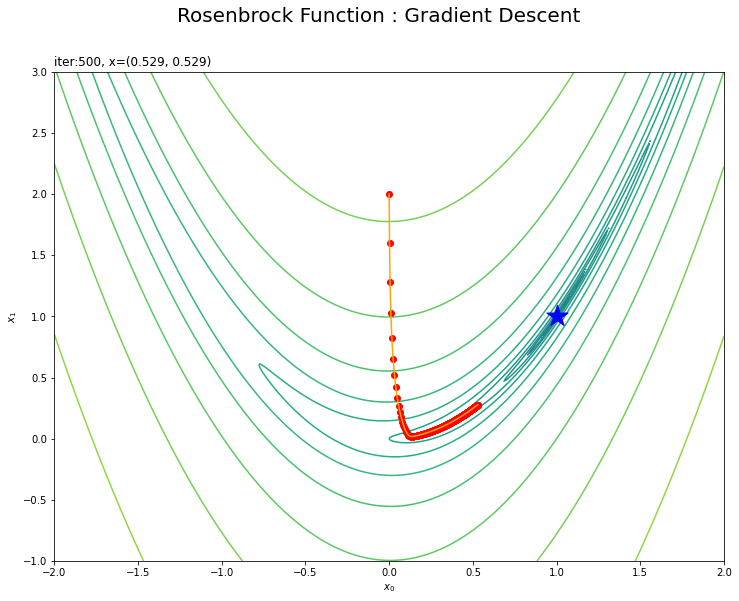

In [108]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

# トレースプロットを作成
plt.figure(figsize=(12, 9))
plt.contour(x0_grid, x1_grid, y_grid, norm=LogNorm(), levels=levs, zorder=0) # ローゼンブロック関数
plt.scatter(1.0, 1.0, marker='*', s=500, c='blue') # ローゼンブロック関数の最小値
plt.scatter(x0_list, x1_list, marker='o', color='red') # 更新値
plt.plot(x0_list, x1_list, color='orange') # 経路
plt.xlabel('$x_0$') # x軸ラベル
plt.ylabel('$x_1$') # y軸ラベル
plt.suptitle('Rosenbrock Function : Gradient Descent', fontsize=20) # 図全体のタイトル
plt.title('iter:' + str(iters) + 
          ', x=(' + str(np.round(x0.data.item(), 3)) + ', ' + str(np.round(x0.data.item(), 3)) + ')', 
          loc='left') # タイトル
plt.show()

さらに回数を重ねて、たとえば
iters=50000 とすれば、実際に(1.0, 1.0) の場所に辿り着きます。
以上で本ステップの作業は終わりです。ここではDeZero を使って勾配降下法を
実装し、ローゼンブロック関数の最小値の場所を見つけることができました。しか
し、50,000 回の繰り返しはさすがに多すぎでしょう。実は勾配降下法は、ローゼン
ブロック関数のような谷間が長く伸びた関数は苦手なのです。次のステップでは、別
の最適化手法を紹介し、その実装を行います。